In [1]:
import geopandas as gpd
import cartopy.feature as cfeature
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import array_bounds
import ultraplot as uplt
import cartopy.crs as ccrs
import rasterio as rio
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches

## Load Data

In [2]:
new_york_2019 = rio.open('./Data/AerialSurvey/as_satellite_comp_1000_2019.tif', 'r')

In [4]:
dest_crs = ccrs.AlbersEqualArea(central_longitude=-76.0, central_latitude=42.0,)

def prepare_for_viz(raster_file, dest_crs):
    transform, width, height = calculate_default_transform(
        raster_file.crs, dest_crs, raster_file.width, raster_file.height, *raster_file.bounds)
    
    new_image, new_transform = reproject(
        source=raster_file.read(),
        src_transform=raster_file.transform,
        src_crs=raster_file.crs,
        dst_crs=dest_crs,
        resampling=Resampling.nearest,
        dst_nodata=np.nan)

    new_image = new_image.transpose([1, 2, 0])
    new_bounds = array_bounds(new_image.shape[0], new_image.shape[1], new_transform)
    
    return new_image, new_bounds

# 2019
image_2019, bounds_2019 = prepare_for_viz(new_york_2019, dest_crs)

In [5]:
def add_raster_data(ax, image, bounds, year, crs, vmin, vmax, cmap):
    m = ax.imshow(image, cmap=cmap, levels=np.linspace(vmin, vmax, 11), transform=crs,
                  extent=[bounds[0], bounds[2], bounds[1], bounds[3]])
    ax.format(grid=False, facecolor='white', title=str(year))
    ax.set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.STATES)
    
    return m

In [6]:
def classify(image, threshold):
    image_thresh = image.copy()
    image_thresh = np.greater(image, threshold, out=image_thresh, where=~np.isnan(image))
    return image_thresh

In [7]:
cutoff = 0.1

threshold_2019 = classify(image_2019[:, :, 0], cutoff)
threshold_2020 = classify(image_2020[:, :, 0], cutoff)
threshold_2021 = classify(image_2021[:, :, 0], cutoff)
threshold_2022 = classify(image_2022[:, :, 0], cutoff)
threshold_2023 = classify(image_2023[:, :, 0], cutoff)

## 2019 Example

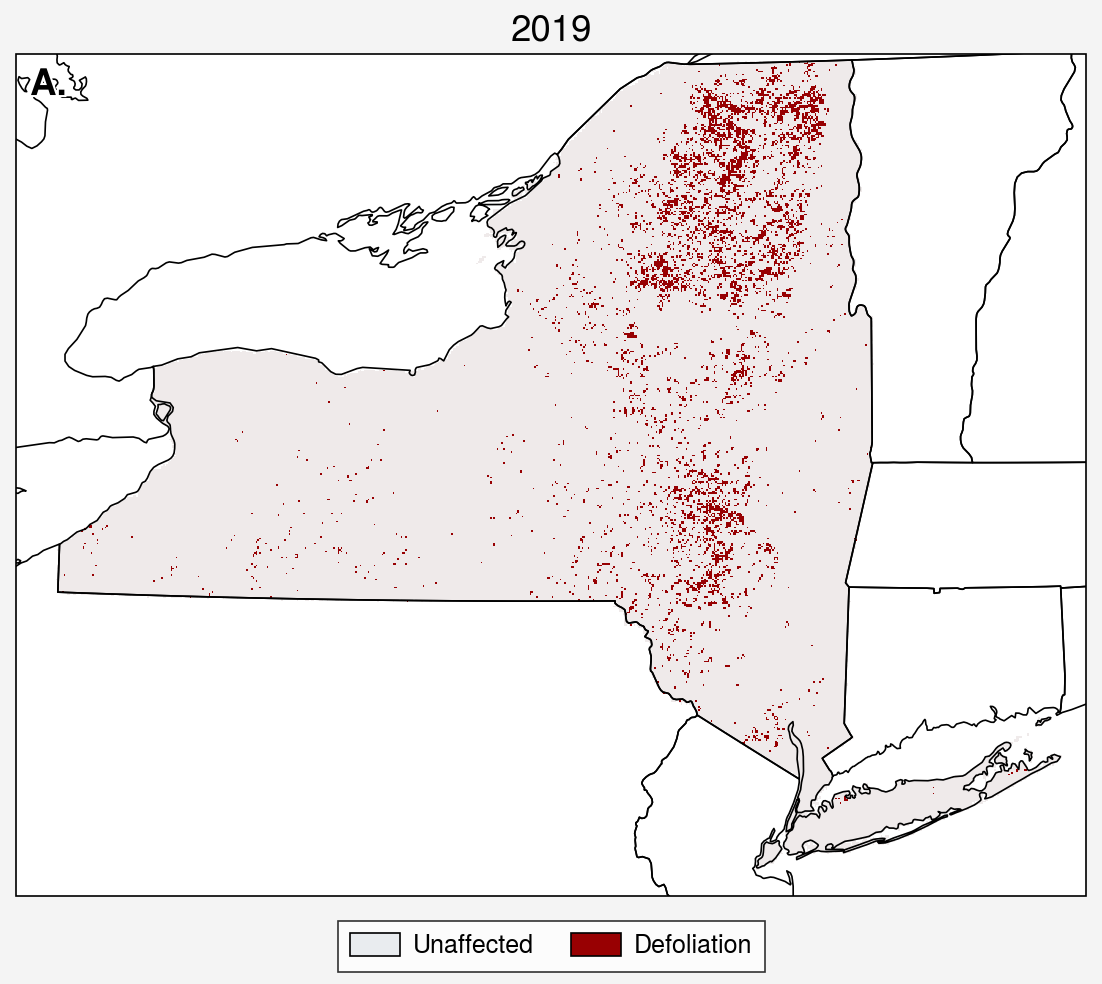

In [13]:
fig, axes = uplt.subplots(figsize=('140mm','125mm'), proj={(1):dest_crs}, facecolor='white', fontsize=12)

axes.format(abc='A.', abcloc='ul')

vmax = 1
vmin = 0
cmap = ['gray2', 'blood red']

# Yearly raster images
add_raster_data(axes[0], threshold_2019, bounds_2019, 2019, dest_crs, vmin, vmax, cmap)
    
no_patch = mpatches.Patch(facecolor=cmap[0], label='Unaffected', edgecolor='black')
defol_patch = mpatches.Patch(facecolor=cmap[1], label='Defoliation', edgecolor='black')
fig.legend(handles=[no_patch, defol_patch], loc='b', ncols=2)

fig.savefig('./Figures/YearlyExtent/year_map_upscaled_2019.png')